In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Inverting sequence

### Grammar
#### invert a sequence of numbers
ex) '1', '2', '5', '2', '2', '6', '5', '1' -> '1', '5', '6', '2', '2', '5', '2', '1'

In [2]:
import random
def invert_seq(data_size=5000):
    dataset = []
    for _ in range(data_size):
        length = random.randint(3, 4)
        seq = [str(random.randint(0, 9)) for _ in range(length)]
        target = seq
        dataset.append((seq, target))
    return dataset

In [3]:
from my_utils import Dictionary

src_dict = Dictionary(['<EOS>'])
tgt_dict = Dictionary(['<BOS>', '<EOS>'])
for n in '0123456789':
    src_dict.add_word(n)
    tgt_dict.add_word(n)

In [4]:
train = invert_seq(50000)
test = invert_seq(100)

In [5]:
from my_utils import DataLoader
from torch_models.utils import seq2seq, get_device

def numericalize(dataset, src_dict, tgt_dict):
    numericalized = [([src_dict(s) for s in src], [tgt_dict(t) for t in tgt]) for src, tgt in dataset]
    return numericalized

device = get_device()
train_loader = DataLoader(numericalize(train, src_dict, tgt_dict), batch_size=64, trans_func=seq2seq)
test_loader = DataLoader(numericalize(test, src_dict, tgt_dict), batch_size=16, trans_func=seq2seq)

===== Device =====
cpu


In [6]:
from torch_models import AttnSeq2Seq, Seq2Seq

In [7]:
dim = 100
model = AttnSeq2Seq(dim, dim, len(src_dict), len(tgt_dict),
                    tgt_BOS=tgt_dict('<BOS>'), tgt_EOS=tgt_dict('<EOS>'), src_EOS=src_dict('<EOS>'),
                    num_layers=1, bidirectional=True)
print(model)

AttnSeq2Seq(
  (encoder): LSTMEncoder(
    (embedding): Embedding(12, 100, padding_idx=11)
    (rnn): LSTM(100, 100, bidirectional=True)
  )
  (decoder): LSTMEncoder(
    (embedding): Embedding(13, 100, padding_idx=12)
    (rnn): LSTM(100, 200)
  )
  (out_mlp): MLP(
    (fc_out): Linear(in_features=400, out_features=12, bias=True)
    (dropout): Dropout(p=0)
    (criterion): CrossEntropyLoss()
    (activation): Tanh()
  )
)


In [8]:
from my_utils import Trainer, EvaluatorC
from torch.optim import Adam

optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()))

# evaluator = EvaluatorC(model, test_loader)

trainer = Trainer(model, train_loader)
trainer.train(optimizer, max_epoch=5,
              evaluator=None, score_monitor=None, show_log=True, hook_func=None)

epoch 0  	loss: 0.22988738413528562	
epoch 1  	loss: 0.004090993404638527	
epoch 2  	loss: 0.0029984384718889376	


KeyboardInterrupt: 

In [10]:
# iter(train_loader)
inputs, target = next(train_loader)
l = 10
generated, attn = model.generate(inputs[:l], 20, True)
print('======= input ======')
for seq in inputs[:l]:
    print([src_dict(s.item()) for s in seq])
print('======= output ======')
for seq in generated:
    print([tgt_dict(s) for s in seq])

======= input ======
['5', '8', '8']
['0', '3', '0']
['1', '9', '5']
['3', '4', '0']
['6', '3', '7', '7']
['2', '2', '8']
['0', '1', '8']
['0', '7', '8', '1']
['4', '4', '4']
['0', '5', '9', '0']
======= output ======
['5', '8', '8']
['0', '3', '0']
['1', '9', '5']
['3', '4', '0']
['6', '3', '7']
['2', '2', '8']
['0', '1', '8']
['0', '7', '8', '1']
['4', '4', '4']
['0', '5', '0']


<IPython.core.display.Javascript object>


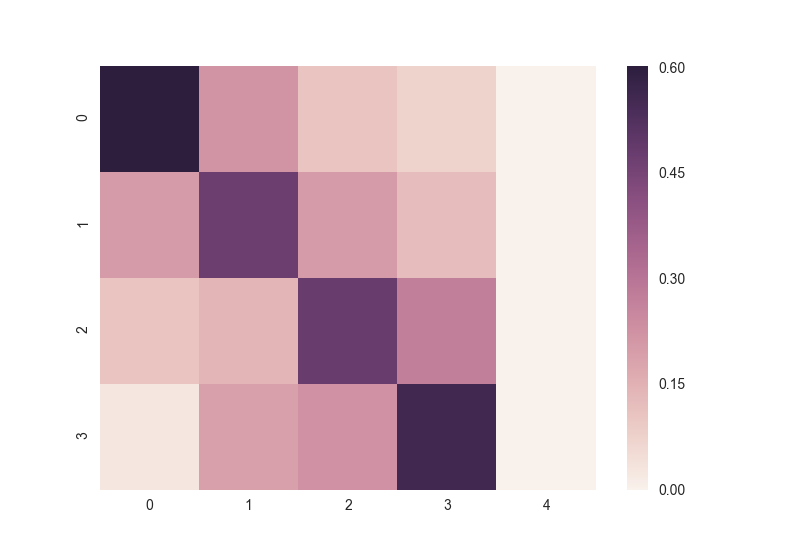

In [12]:
import torch
import seaborn as sns
sns.heatmap(torch.cat(attn[1]).squeeze().data.numpy())